In [1]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage

# MagAO-X function definitions
import magaoxFunctions as mf
# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
import h5py
import copy
import PSD_defns as psd

In [170]:
def is_odd(num):
    return num%2 != 0

is_odd(4)

False

In [11]:
# call in coastline data and convert it to usable data and into FITS
cl_raw = h5py.File('zygo_data/flat_mirrors/coastline.datx')
cl_data = cl_raw['Measurement']['Surface'].value
cl_attr = cl_raw['Measurement']['Surface'].attrs
attr = cl_raw['Measurement']['Attributes'].attrs
cl_latres = attr['Surface Data Context.Lateral Resolution:Value'][0]
mask = np.ones_like(cl_data).astype(bool)
mask[cl_data==cl_attr['No Data']] = 0
cl_data[~mask]=0
# convert data from wavefront to surface in microns
cl_data *= cl_attr['Interferometric Scale Factor'][0] * cl_attr['Wavelength'][0] *1e6

# Fill in FITS header
cl_header = fits.Header()
cl_header['WAVELEN'] = (cl_attr['Wavelength'][0], 'Zygo wavelength, [meter]')
cl_header['LATRES'] = (cl_latres, 'Lateral Resolution across mask diameter, [m/pix]')
cl_header['DATATYPE'] = ('surface', 'Data type, Surface or Wavelength')
cl_header['DATAUNITS'] = ('micrometers', 'Data units, length or waves')

# save to FITS file
fits_file_loc = 'zygo_data/flat_mirrors/coastline_flat_raw.fits'
fits.writeto(fits_file_loc, cl_data, cl_header)

In [94]:
cl_attr['Wavelength'][0]

6.327999813038332e-07

In [161]:
# crop the data, based on ds9 opening original data
cy = 115
cx = 125
cr = 115
crop_cl = cl_data[cy-cr:cy+cr, cx-cr:cx+cr]

#save to FITS file
fits_file_loc = 'zygo_data/flat_mirrors/coastline_flat_correct.fits'
fits.writeto(fits_file_loc, crop_cl, cl_header)

In [160]:
np.shape(crop_cl)

(230, 230)

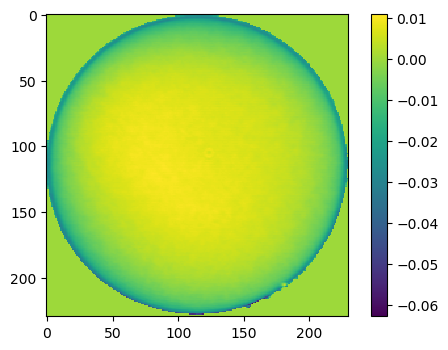

In [66]:
# verify crop is correct
plt.figure(dpi=100)
plt.imshow(crop_cl)
plt.colorbar()

In [76]:
# draw the masks
from skimage.draw import draw # drawing tools for dark hole mask

data_side = np.shape(crop_cl)[0]

ca_100 = np.zeros((data_side, data_side), dtype=np.uint8)
m100_coords = draw.circle(data_side/2, data_side/2, radius=data_side/2)
ca_100[m100_coords] = True

ca_80 = np.zeros((data_side, data_side), dtype=np.uint8)
m80_coords = draw.circle(data_side/2, data_side/2, radius=(data_side/2)*0.8)
ca_80[m80_coords] = True

npix_diam = np.int(data_side*0.8)
npix_diam

# check the data
#plt.imshow(ca_80)
#plt.imshow(ca_100)

184

In [158]:
fits_file_loc = 'zygo_data/flat_mirrors/coastline_80mask.fits'
fits.writeto(fits_file_loc, ca_80)

In [96]:
# convert the optic data into millimeters from microns
optic_data = crop_cl*1e-3

# calculate the mean and variance of the data
active_ap = optic_data * ca_80
active_ap_coords = optic_data[ca_80==True]
ap_avg = np.mean(active_ap_coords) # units: mm
ap_var = np.var(active_ap_coords) # units: mm^2
ap_avg, ap_var

(5.212337503653021e-06, 8.89079259999503e-12)

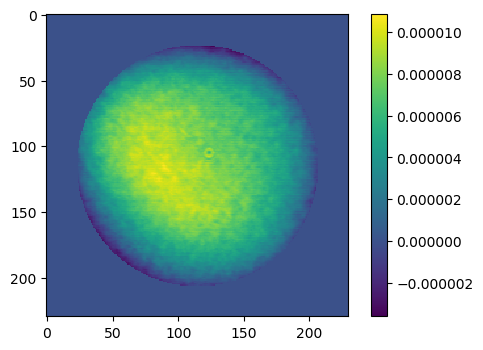

In [69]:
plt.figure(dpi=100)
plt.imshow(active_ap)
plt.colorbar()

Text(0.5, 1.0, 'coastline flat, (80% CA), mean subtracted')

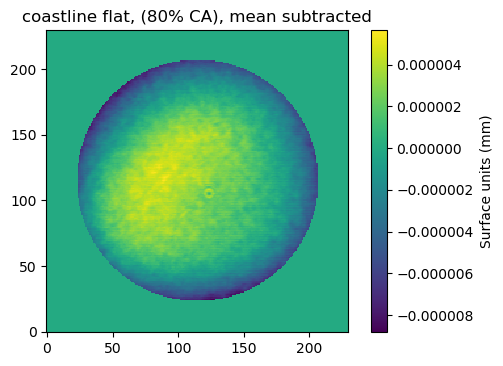

In [122]:
# subtract the mean
ap_submean = (active_ap - ap_avg)*ca_80
plt.figure(dpi=100)
plt.imshow(ap_submean, origin='lower')
plt.colorbar().set_label('Surface units (mm)')
plt.title('coastline flat, (80% CA), mean subtracted')

In [123]:
# build 2D Hann window function for the 80% CA mask
hannSide = signal.hann(npix_diam)
hannArray = np.tile(hannSide,(npix_diam,1))
hannWin = hannArray*hannSide[:,np.newaxis]
np.shape(hannWin)

(184, 184)

In [124]:
# Zero Pad the window to fit the data dimensions
pad_side = np.int((np.shape(optic_data)[0] - npix_diam)/2)
phann = np.pad(hannWin, pad_side, mf.pad_with)*ca_80
np.shape(phann)

(230, 230)

Text(0.5, 1.0, 'Mean subtracted, 2D Hann window')

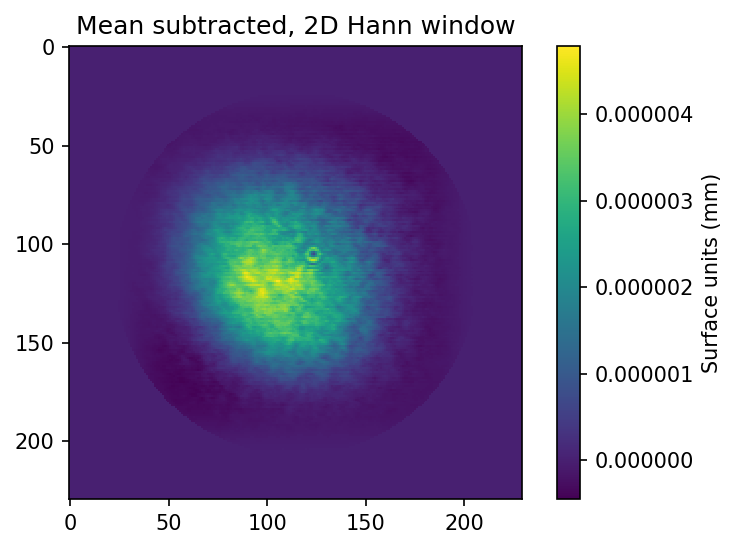

In [125]:
# apply window
ap_win = ap_submean * phann

plt.figure(dpi=150)
plt.imshow(ap_win)
plt.colorbar().set_label('Surface units (mm)')
plt.title('Mean subtracted, 2D Hann window')

In [126]:
# oversample the data to prepare for FFTs
oversamp = 16
optic_wf = psd.zeroPadOversample(ap_win,oversamp)
power_optic = psd.calcPower2(optic_wf)
np.shape(optic_wf)

(4096, 4096)

In [83]:
# build spatial frequency map based on oversample array size
ca80_diam = 50*0.8 * u.mm # units: mm, 80% CA
sample_space = ca80_diam/ (npix_diam*u.pix) # always stays the same, this is step size for pixel
delta_k = 1/(np.shape(optic_wf)[0]*u.pix*sample_space).value
FT_freq = np.fft.fftfreq(n=np.shape(optic_wf)[0],d=sample_space)
kx=np.resize(FT_freq,(FT_freq.size, FT_freq.size))
y_val = np.reshape(FT_freq,(FT_freq.size,1))
ky = y_val
for m in range(0,y_val.size-1):
    ky = np.hstack((ky,y_val))
magK = np.fft.fftshift(np.sqrt(kx*kx + ky*ky))

Text(0.5, 1.0, 'magK map')

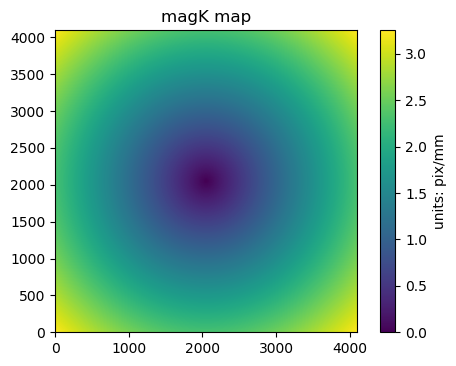

In [84]:
plt.figure(dpi=100)
plt.imshow(magK, origin='lower')
plt.colorbar().set_label('units: pix/mm')
plt.title('magK map')

In [127]:
# PSD normalization
sig_sq_tot = np.sum(power_optic)*((delta_k)**2)
scale_factor = sig_sq_tot / ap_var
norm_psd = power_optic / scale_factor

# check that the normalized PSD matches the aperture variance
np.allclose(np.sum(norm_psd)*(delta_k**2), ap_var)

True

In [128]:
# make grid for the ring to mask for average radial power value
shift=np.int(FT_freq.size/2)
maskY,maskX = np.ogrid[-shift:shift, -shift:shift]

# get the whole range of radial frequency
# it's radially symmetric, so cut to center line, then get right side for range.
radialFreq = magK[shift][shift:(2*shift)]
#k_val.append(radialFreq[r])

# initialize content
mean_val = [] # initialize empty list of median power values
k_val = [] # initialize empty list of frequencies

# set up radial ring parameters
dr=5 # 5 width, so 2 behind, 1 center, 2 front
r_halfside = np.int((dr-1)/2) # halfside for r
r=1 # initialize r value

# chug along through all the radial frequency values
while((r+r_halfside)<shift):
    ri = r - r_halfside # inner radius
    if ri > 0: # Only start adding in values when the inner radius is greater than 1
        radial_mask = psd.makeRingMask(maskY,maskX,ri,dr)
        radial_bin = psd.makeRingMaskBin(norm_psd,radial_mask)
        mean_val.append(np.mean(radial_bin))
        k_val.append(radialFreq[r])
    r+=5 # iterate to the next r value in the loop.

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

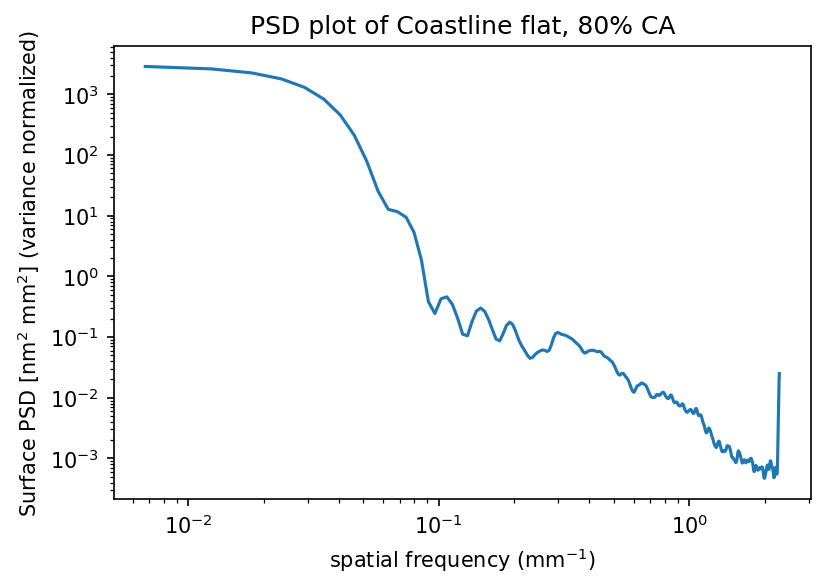

In [129]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
mean_val_nm2 = [i*1e12 for i in mean_val]
plt.figure(dpi=150)
plt.loglog(k_val, mean_val_nm2)
plt.title('PSD plot of Coastline flat, 80% CA')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

Text(0, 0.5, 'Surface PSD [mm$^{2}$ mm$^{2}$] (variance normalized)')

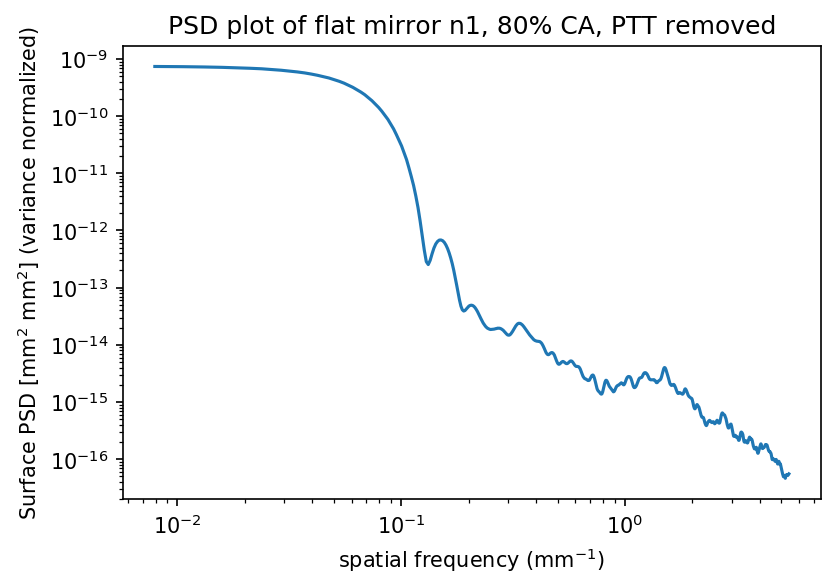

In [289]:
plt.figure(dpi=150)
plt.loglog(k_val, mean_val)
plt.title('PSD plot of Coastline flat, 80% CA')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [mm$^{2}$ mm$^{2}$] (variance normalized)') 

### Let's try with Kyle's 2D Hanning window.
THIS WORKED OMG

In [130]:
def get_radial_dist(shape, scaleyx=(1.0, 1.0)):
    '''
    Compute the radial separation of each pixel
    from the center of a 2D array, and optionally 
    scale in x and y.
    '''
    indices = np.indices(shape)
    cenyx = ( (shape[0] - 1) / 2., (shape[1] - 1)  / 2.)
    radial = np.sqrt( (scaleyx[0]*(indices[0] - cenyx[0]))**2 + (scaleyx[1]*(indices[1] - cenyx[1]))**2 )
    return radial

def han2d(shape, fraction=1./np.sqrt(2), normalize=False):
    '''
    Radial Hanning window scaled to a fraction 
    of the array size.
    
    Fraction = 1. for circumscribed circle
    Fraction = 1/sqrt(2) for inscribed circle (default)
    '''
    #return np.sqrt(np.outer(np.hanning(shape[0]), np.hanning(shape[0])))

    # get radial distance from center
    radial = get_radial_dist(shape)

    # scale radial distances
    rmax = radial.max() * fraction
    scaled = (1 - radial / rmax) * np.pi/2.
    window = np.sin(scaled)**2
    window[radial > fraction * radial.max()] = 0.
    return window

(184, 184)

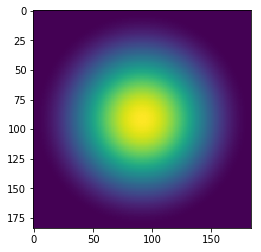

In [133]:
new_hann = han2d((npix_diam, npix_diam))
plt.imshow(new_hann)
np.shape(new_hann)

In [162]:
np.shape(phann_test)

(230, 230)

Text(0.5, 1.0, 'Mean subtracted, 2D Hann window')

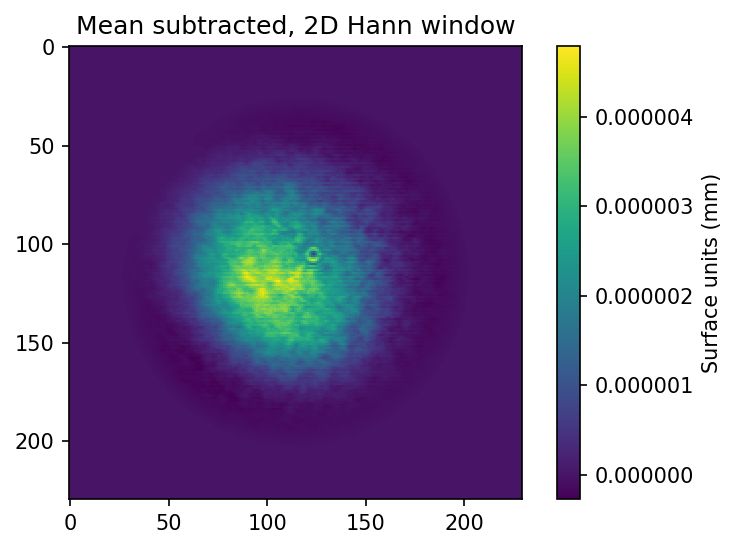

In [134]:
# Zero Pad the window to fit the data dimensions
pad_side = np.int((np.shape(optic_data)[0] - npix_diam)/2)
phann_test = np.pad(new_hann, pad_side, mf.pad_with)*ca_80
np.shape(phann_test)

# apply window
ap_win_test = ap_submean * phann_test

plt.figure(dpi=150)
plt.imshow(ap_win_test)
plt.colorbar().set_label('Surface units (mm)')
plt.title('Mean subtracted, 2D Hann window')

In [135]:
# oversample the data to prepare for FFTs
oversamp = 16
optic_wf_test = psd.zeroPadOversample(ap_win_test,oversamp)
power_optic_test = psd.calcPower2(optic_wf_test)
np.shape(optic_wf_test)

(4096, 4096)

In [151]:
# build spatial frequency map based on oversample array size
ca80_diam = 50*0.8 * u.mm # units: mm, 80% CA
sample_space = ca80_diam/ (npix_diam*u.pix) # always stays the same, this is step size for pixel
delta_k = 1/(np.shape(optic_wf)[0]*u.pix*sample_space).value
FT_freq = np.fft.fftfreq(n=np.shape(optic_wf)[0],d=sample_space)

In [152]:
# PSD normalization
sig_sq_tot_test = np.sum(optic_wf_test)*((delta_k)**2)
scale_factor_test = sig_sq_tot_test / ap_var
norm_psd_test = power_optic_test / scale_factor_test

# check that the normalized PSD matches the aperture variance
np.allclose(np.sum(norm_psd_test)*(delta_k**2), ap_var)

True

In [168]:
sig_sq_tot = np.sum(power_optic_test)*((delta_k)**2)
sig_sq_tot

9.581767943910479e-07

In [166]:
sig_sq_tot_test

2.3456020872852025e-08

In [165]:
scale_factor_test

2638.237323505346

In [163]:
# make grid for the ring to mask for average radial power value
shift=np.int(FT_freq.size/2)
maskY,maskX = np.ogrid[-shift:shift, -shift:shift]

# get the whole range of radial frequency
# it's radially symmetric, so cut to center line, then get right side for range.
radialFreq = FT_freq[0:shift].value
#k_val.append(radialFreq[r])

# initialize content
mean_val_test = [] # initialize empty list of median power values
k_val_test = [] # initialize empty list of frequencies

# set up radial ring parameters
dr=5 # 5 width, so 2 behind, 1 center, 2 front
r_halfside = np.int((dr-1)/2) # halfside for r
r=1 # initialize r value

# chug along through all the radial frequency values
while((r+r_halfside)<shift):
    ri = r - r_halfside # inner radius
    if ri > 0: # Only start adding in values when the inner radius is greater than 1
        radial_mask = psd.makeRingMask(maskY,maskX,ri,dr)
        radial_bin = psd.makeRingMaskBin(norm_psd_test,radial_mask)
        mean_val_test.append(np.mean(radial_bin))
        k_val_test.append(radialFreq[r])
    r+=5 # iterate to the next r value in the loop.

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

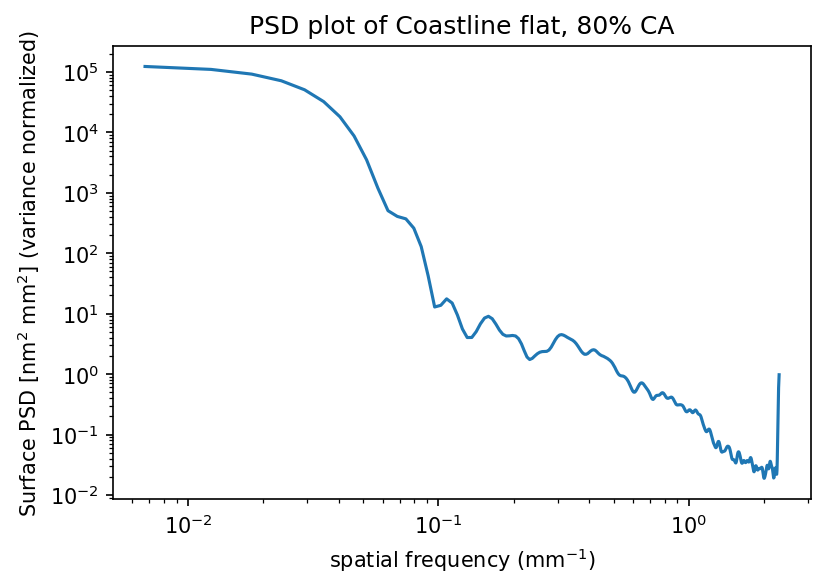

In [164]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
mean_val_nm2_test = [i*1e12 for i in mean_val_test]
plt.figure(dpi=150)
plt.loglog(k_val_test, mean_val_nm2_test)
plt.title('PSD plot of Coastline flat, 80% CA')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

In [153]:
# make grid for the ring to mask for average radial power value
shift=np.int(FT_freq.size/2)
maskY,maskX = np.ogrid[-shift:shift, -shift:shift]

# get the whole range of radial frequency
# it's radially symmetric, so cut to center line, then get right side for range.
radialFreq = FT_freq[0:shift].value
#k_val.append(radialFreq[r])

# initialize content
mean_val_test = [] # initialize empty list of median power values
k_val_test = [] # initialize empty list of frequencies

# set up radial ring parameters
dr=5 # 5 width, so 2 behind, 1 center, 2 front
r_halfside = np.int((dr-1)/2) # halfside for r
r=1 # initialize r value

# chug along through all the radial frequency values
while((r+r_halfside)<shift):
    ri = r - r_halfside # inner radius
    if ri > 0: # Only start adding in values when the inner radius is greater than 1
        radial_mask = psd.makeRingMask(maskY,maskX,ri,dr)
        radial_bin = psd.makeRingMaskBin(norm_psd_test,radial_mask)
        mean_val_test.append(np.mean(radial_bin))
        k_val_test.append(radialFreq[r])
    r+=5 # iterate to the next r value in the loop.

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

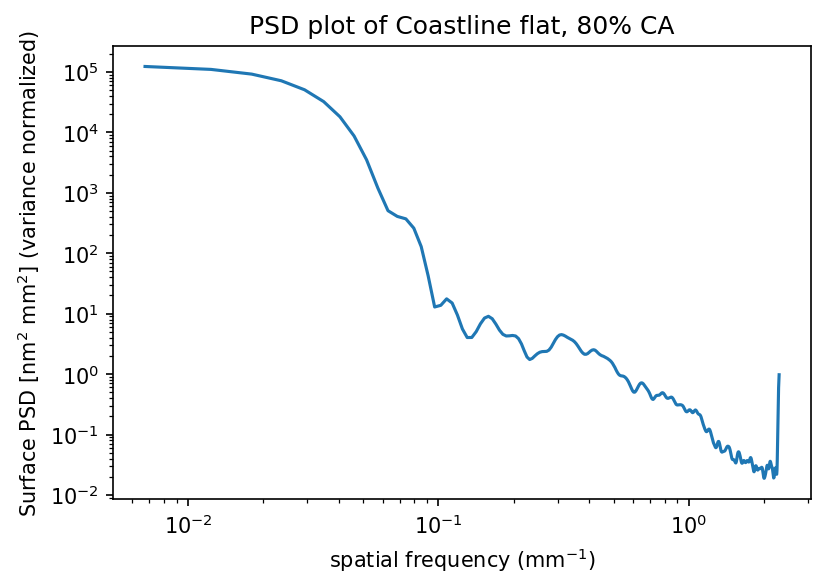

In [154]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
mean_val_nm2_test = [i*1e12 for i in mean_val_test]
plt.figure(dpi=150)
plt.loglog(k_val_test, mean_val_nm2_test)
plt.title('PSD plot of Coastline flat, 80% CA')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

### What if the original hann window is wrong?

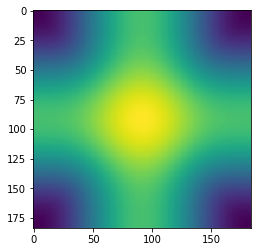

In [113]:
# build 2D Hann window function for the 80% CA mask
hannSide = signal.hann(npix_diam)
hannArray = np.tile(hannSide,(npix_diam,1))
hann_x = hannArray
hann_y = np.transpose(hannArray)
hannWin_test = np.sqrt((hann_x*hann_x) + (hann_y*hann_y))
plt.imshow(hannWin_test)

Text(0.5, 1.0, 'Mean subtracted, 2D Hann window')

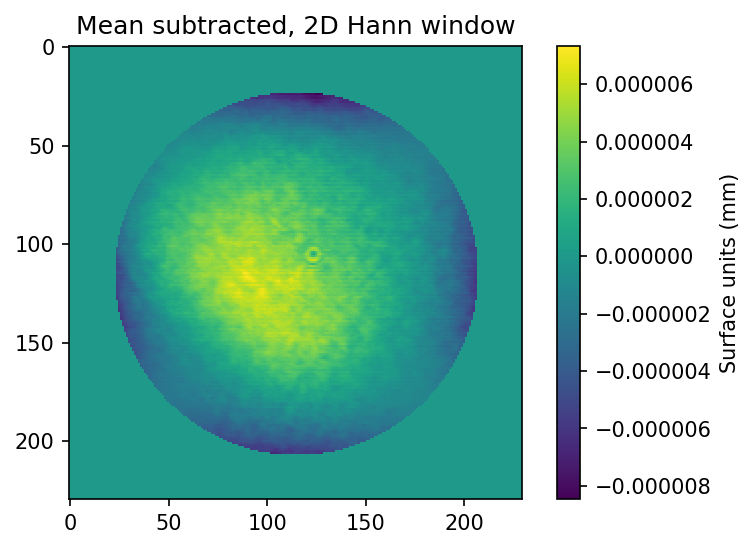

In [114]:
# Zero Pad the window to fit the data dimensions
pad_side = np.int((np.shape(optic_data)[0] - npix_diam)/2)
phann_test = np.pad(hannWin_test, pad_side, mf.pad_with)*ca_80
np.shape(phann_test)

# apply window
ap_win_test = ap_submean * phann_test

plt.figure(dpi=150)
plt.imshow(ap_win_test)
plt.colorbar().set_label('Surface units (mm)')
plt.title('Mean subtracted, 2D Hann window')

In [115]:
# oversample the data to prepare for FFTs
oversamp = 16
optic_wf_test = psd.zeroPadOversample(ap_win_test,oversamp)
power_optic_test = psd.calcPower2(optic_wf_test)
np.shape(optic_wf_test)

(4096, 4096)

In [116]:
# build spatial frequency map based on oversample array size
ca80_diam = 50*0.8 * u.mm # units: mm, 80% CA
sample_space = ca80_diam/ (npix_diam*u.pix) # always stays the same, this is step size for pixel
delta_k = 1/(np.shape(optic_wf)[0]*u.pix*sample_space).value

FT_freq = np.fft.fftfreq(n=np.shape(optic_wf)[0],d=sample_space)
kx=np.resize(FT_freq,(FT_freq.size, FT_freq.size))
y_val = np.reshape(FT_freq,(FT_freq.size,1))
ky = y_val
for m in range(0,y_val.size-1):
    ky = np.hstack((ky,y_val))
magK = np.fft.fftshift(np.sqrt(kx*kx + ky*ky))

Text(0.5, 1.0, 'magK map')

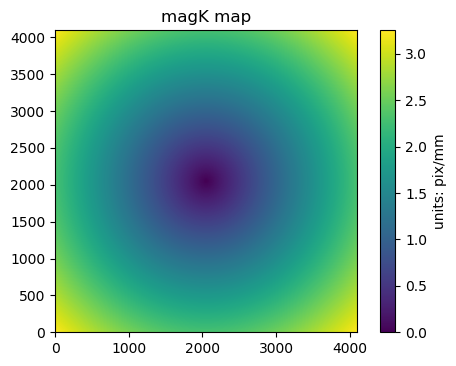

In [117]:
plt.figure(dpi=100)
plt.imshow(magK, origin='lower')
plt.colorbar().set_label('units: pix/mm')
plt.title('magK map')

In [118]:
# PSD normalization
sig_sq_tot_test = np.sum(optic_wf_test)*((delta_k)**2)
scale_factor_test = sig_sq_tot_test / ap_var
norm_psd_test = power_optic_test / scale_factor_test

# check that the normalized PSD matches the aperture variance
np.allclose(np.sum(norm_psd_test)*(delta_k**2), ap_var)

True

In [119]:
# make grid for the ring to mask for average radial power value
shift=np.int(FT_freq.size/2)
maskY,maskX = np.ogrid[-shift:shift, -shift:shift]

# get the whole range of radial frequency
# it's radially symmetric, so cut to center line, then get right side for range.
radialFreq = magK[shift][shift:(2*shift)]
#k_val.append(radialFreq[r])

# initialize content
mean_val_test = [] # initialize empty list of median power values
k_val_test = [] # initialize empty list of frequencies

# set up radial ring parameters
dr=5 # 5 width, so 2 behind, 1 center, 2 front
r_halfside = np.int((dr-1)/2) # halfside for r
r=1 # initialize r value

# chug along through all the radial frequency values
while((r+r_halfside)<shift):
    ri = r - r_halfside # inner radius
    if ri > 0: # Only start adding in values when the inner radius is greater than 1
        radial_mask = psd.makeRingMask(maskY,maskX,ri,dr)
        radial_bin = psd.makeRingMaskBin(norm_psd,radial_mask)
        mean_val_test.append(np.mean(radial_bin))
        k_val_test.append(radialFreq[r])
    r+=5 # iterate to the next r value in the loop.

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

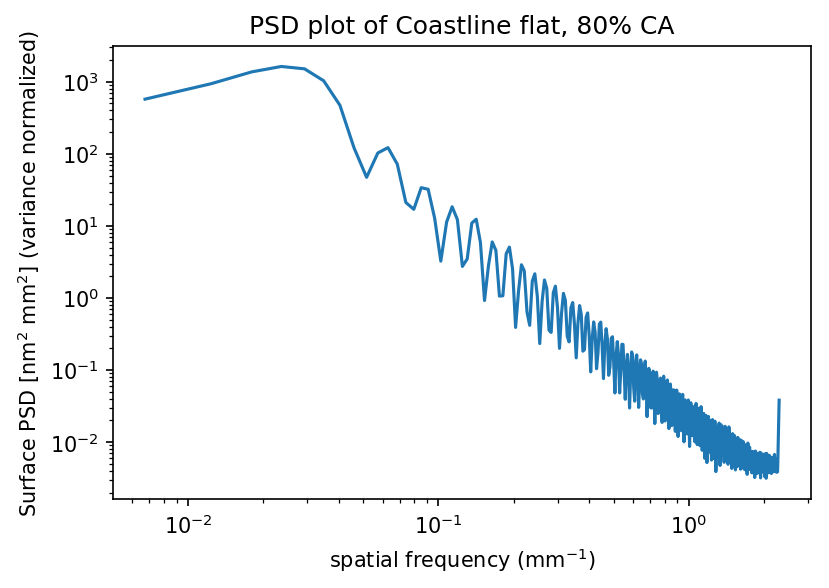

In [121]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
mean_val_nm2_test = [i*1e12 for i in mean_val_test]
plt.figure(dpi=150)
plt.loglog(k_val_test, mean_val_nm2_test)
plt.title('PSD plot of Coastline flat, 80% CA')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

### What if you don't use a window?

In [97]:
# oversample the data to prepare for FFTs
oversamp = 16
optic_wf = psd.zeroPadOversample(ap_submean,oversamp)
power_optic = psd.calcPower2(optic_wf)

# PSD normalization
sig_sq_tot = np.sum(power_optic)*((delta_k)**2)
scale_factor = sig_sq_tot / ap_var
norm_psd = power_optic / scale_factor

# check that the normalized PSD matches the aperture variance
np.allclose(np.sum(norm_psd)*(delta_k**2), ap_var)

True

In [98]:
# initialize content
mean_val_nw = [] # initialize empty list of median power values
k_val_nw = [] # initialize empty list of frequencies

# set up radial ring parameters
dr=5 # 5 width, so 2 behind, 1 center, 2 front
r_halfside = np.int((dr-1)/2) # halfside for r
r=1 # initialize r value

# chug along through all the radial frequency values
while((r+r_halfside)<shift):
    ri = r - r_halfside # inner radius
    if ri > 0: # Only start adding in values when the inner radius is greater than 1
        radial_mask = psd.makeRingMask(maskY,maskX,ri,dr)
        radial_bin = psd.makeRingMaskBin(norm_psd,radial_mask)
        mean_val_nw.append(np.mean(radial_bin))
        k_val_nw.append(radialFreq[r])
    r+=1 # iterate to the next r value in the loop.

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

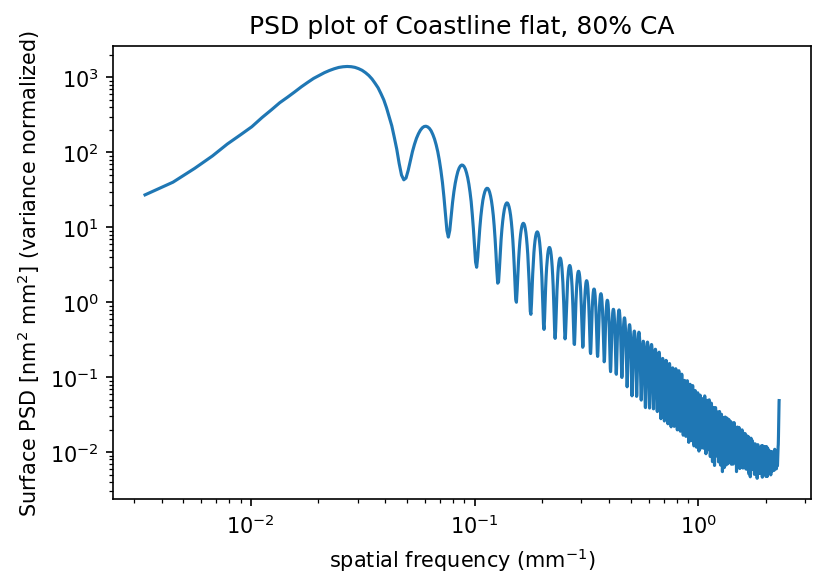

In [99]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
mean_val_nm2_nw = [i*1e12 for i in mean_val_nw]
plt.figure(dpi=150)
plt.loglog(k_val, mean_val_nm2_nw)
plt.title('PSD plot of Coastline flat, 80% CA')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 